# Initial Setup

In [ ]:
import os
import warnings

from pyro import set_rng_seed

# Omit warnings during notebook runtime
os.environ["PYTHONWARNINGS"] = "ignore"
warnings.filterwarnings("ignore")

# Set random seed for PyTorch and Pyro
seed = 0
set_rng_seed(seed)

/Users/zarizky/Projects/tcga-pancancer/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train GMVAE

In [ ]:
import scanpy as sc
import torch
from anndata.experimental.pytorch import AnnLoader
from pyro import clear_param_store
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import StepLR
from pyro.optim.clipped_adam import ClippedAdam
from torch.nn.utils.parametrizations import orthogonal
from tqdm import trange

from vae4counts.models import CountGMVAE

# Hyperparameters

# Model
num_latents = 16
num_components = 8
output_dist = "zi_nb"
feature_scaler = "log1p"

num_hiddens_mixing_encoder = [128] * 2
num_hiddens_comp_encoder = [64] * 2
num_hiddens_freq_scale_encoder = [128] * 2
num_hiddens_decoder = None

mixing_encoder_kwargs = {"mlp": {"norm": "batch", "act": "relu"}}
comp_encoder_kwargs = {
    "mlp": {"norm": "batch", "act": "relu"},
    "probabilistic": {"condition": "additive"},
}
freq_scale_encoder_kwargs = {"mlp": {"norm": "batch", "act": "relu"}}
decoder_kwargs = {"mlp": {"norm": "batch", "act": "relu"}}
scaler_kwargs = {}

use_orth_decoder = False

# Training
device = (
    "mps"
    if torch.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
max_epochs = 100
batch_size = 2048

# Optimizer and step learning rate scheduler
learning_rate = 2e-3
step_size = 10
mul_factor = 0.95

# Data
data_root = "dataset/pbmc68k/scrna-seq.h5ad"
adata = sc.read_h5ad(data_root)
sc.pp.highly_variable_genes(adata, n_top_genes=4096, flavor="seurat_v3", subset=True)

dataloader = AnnLoader(adata, batch_size=batch_size, shuffle=True)

# Clean cache
empty_cache = {"cuda": torch.cuda.empty_cache, "mps": torch.mps.empty_cache}
if device in empty_cache:
    empty_cache[device]()

# Model
gmvae = CountGMVAE(
    num_features=adata.n_vars,
    num_latents=num_latents,
    num_components=num_components,
    output_dist=output_dist,
    feature_scaler=feature_scaler,
    num_hiddens_mixing_encoder=num_hiddens_mixing_encoder,
    num_hiddens_comp_encoder=num_hiddens_comp_encoder,
    num_hiddens_freq_scale_encoder=num_hiddens_freq_scale_encoder,
    num_hiddens_decoder=num_hiddens_decoder,
    mixing_encoder_kwargs=mixing_encoder_kwargs,
    comp_encoder_kwargs=comp_encoder_kwargs,
    freq_scale_encoder_kwargs=freq_scale_encoder_kwargs,
    decoder_kwargs=decoder_kwargs,
    scaler_kwargs=scaler_kwargs,
)
gmvae.fit_freq_scale_prior(torch.tensor(adata.to_df().to_numpy())).to(device)

if use_orth_decoder and device in {"cpu", "cuda"}:
    gmvae.decoder.probs_proj = orthogonal(gmvae.decoder.probs_proj)
elif use_orth_decoder:
    print(
        "Orthogonal parametrization is not supported on 'mps'; using unconstrained decoder."
    )

print(gmvae)

# Inference (SVI)
elbo = TraceEnum_ELBO(max_plate_nesting=1)
scheduler = StepLR(
    {
        "optimizer": ClippedAdam,
        "optim_args": {"lr": learning_rate},
        "step_size": step_size * len(dataloader),
        "gamma": mul_factor,
    }
)
svi = SVI(gmvae.model, gmvae.guide, scheduler, elbo)

# Training loop
clear_param_store()

tracker = []
gmvae.train()
for epoch in (pbar := trange(1, max_epochs + 1)):
    pbar.set_description("Training")

    epoch_loss = 0
    for minibatch in dataloader:
        epoch_loss += svi.step(minibatch.X.to(device)) / len(adata)
        scheduler.step()

    epoch_loss = epoch_loss
    tracker.append(epoch_loss)

    pbar.set_postfix(loss=f"{epoch_loss:,.4f}")

CountGMVAE(
  (feature_scaler): Log1P(inplace=False)
  (mixing_encoder): ProbabilisticMLP(
    (mlp): MLP(
      (lin_01): Linear(in_features=4096, out_features=128, bias=True)
      (act_01): ReLU()
      (norm_01): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lin_02): Linear(in_features=128, out_features=128, bias=True)
      (act_02): ReLU()
      (norm_02): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (probs_proj): CategoricalLinear(in_features=128, out_features=8, bias=True)
  )
  (comp_encoder): ProbabilisticMLP(
    (mlp): MLP(
      (lin_01): Linear(in_features=4096, out_features=64, bias=True)
      (act_01): ReLU()
      (norm_01): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lin_02): Linear(in_features=64, out_features=64, bias=True)
      (act_02): ReLU()
      (norm_02): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

Training: 100%|██████████| 100/100 [18:19<00:00, 11.00s/it, loss=339.2737]     


# Evaluate Training Curve

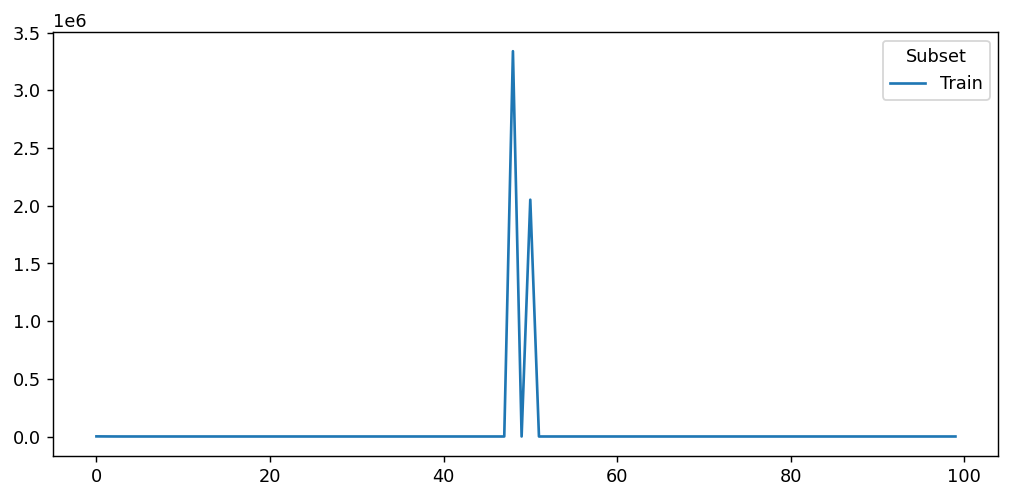

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_tracker = pd.DataFrame({"train": tracker}).rename(columns=lambda k: k.title())

fig, ax = plt.subplots(figsize=(8, 4), dpi=128)

sns.lineplot(data=df_tracker, ax=ax)

if ax.legend_ is not None:
    ax.legend_.set_title("Subset")

fig.tight_layout()
fig.show()

# Analysis

## Extract Latent and UMAP Projection

In [ ]:
import numpy as np
from pyro.distributions import Categorical

with torch.inference_mode():
    gmvae = gmvae.cpu().eval()

    X = torch.as_tensor(adata.to_df().to_numpy())
    mixing_dist, latent_dist, freq_scale_dist = gmvae(X)

    # Cluster assignment + confidence
    maxp, argmax = mixing_dist.probs.max(dim=-1)
    adata.obs["gmvae_probs"] = maxp.detach().cpu().numpy()
    adata.obs["gmvae_cluster"] = (argmax + 1).detach().cpu().numpy().astype(int)
    adata.obs["gmvae_cluster"] = adata.obs["gmvae_cluster"].astype("category")

    # Latent means
    latent_cols = [f"z{i}" for i in range(num_latents)]
    adata.obsm["X_gmvae"] = pd.DataFrame(
        latent_dist.mean.detach().cpu().numpy(),
        index=adata.obs_names,
        columns=latent_cols,
    )

    # Summary stats
    marginal = mixing_dist.probs.mean(dim=0).detach().cpu()
    entropy = Categorical(marginal).entropy().item()

    probs_s = adata.obs["gmvae_probs"]
    near_uniform = (probs_s < 1.5 * (1.0 / num_latents)).mean()

    adata.uns["gmvae_stats"] = {
        "marginal": marginal.numpy(),
        "entropy": entropy,
        "n_eff": float(np.exp(entropy)),
        "maxp_p05": float(probs_s.quantile(0.05)),
        "maxp_p50": float(probs_s.quantile(0.50)),
        "maxp_p95": float(probs_s.quantile(0.95)),
        "frac_near_uniform": float(near_uniform),
        "frac_confident_p50": float((probs_s >= 0.5).mean()),
        "frac_confident_p95": float((probs_s >= 0.95).mean()),
    }

# kNN graph + UMAP (latent space)
sc.pp.neighbors(
    adata,
    n_neighbors=30,
    random_state=seed,
    use_rep="X_gmvae",
    key_added="gmvae",
)

sc.tl.umap(
    adata,
    min_dist=0.3,
    random_state=seed,
    neighbors_key="gmvae",
    key_added="umap_gmvae",
)

## Extract Cluster Statistics

In [ ]:
stats = adata.uns["gmvae_stats"]

print("Cluster Assignment Stats")
print(f"Marginal: {stats['marginal'].round(4)}")
print(f"Marginal Entropy: {stats['entropy']:.4f}")
print(f"Number of Effective Components: {stats['n_eff']:.4f}")
print(f"5% Quantile: {stats['maxp_p05']:.4f}")
print(f"50% Quantile (Median): {stats['maxp_p50']:.4f}")
print(f"95% Quantile: {stats['maxp_p95']:.4f}")
print(f"Uniform Fraction: {stats['frac_near_uniform']:.4f}")
print(f">50% Probability Fraction: {stats['frac_confident_p50']:.4f}")
print(f">95% Probability Fraction: {stats['frac_confident_p95']:.4f}")

Cluster Assignment Stats
Marginal: [0.1545 0.     0.0034 0.     0.2909 0.     0.     0.5511]
Marginal Entropy: 0.9954
Number of Effective Components: 2.7058
5% Quantile: 0.8335
50% Quantile (Median): 1.0000
95% Quantile: 1.0000
Uniform Fraction: 0.0000
>50% Probability Fraction: 1.0000
>95% Probability Fraction: 0.9069


## Extract Covariance

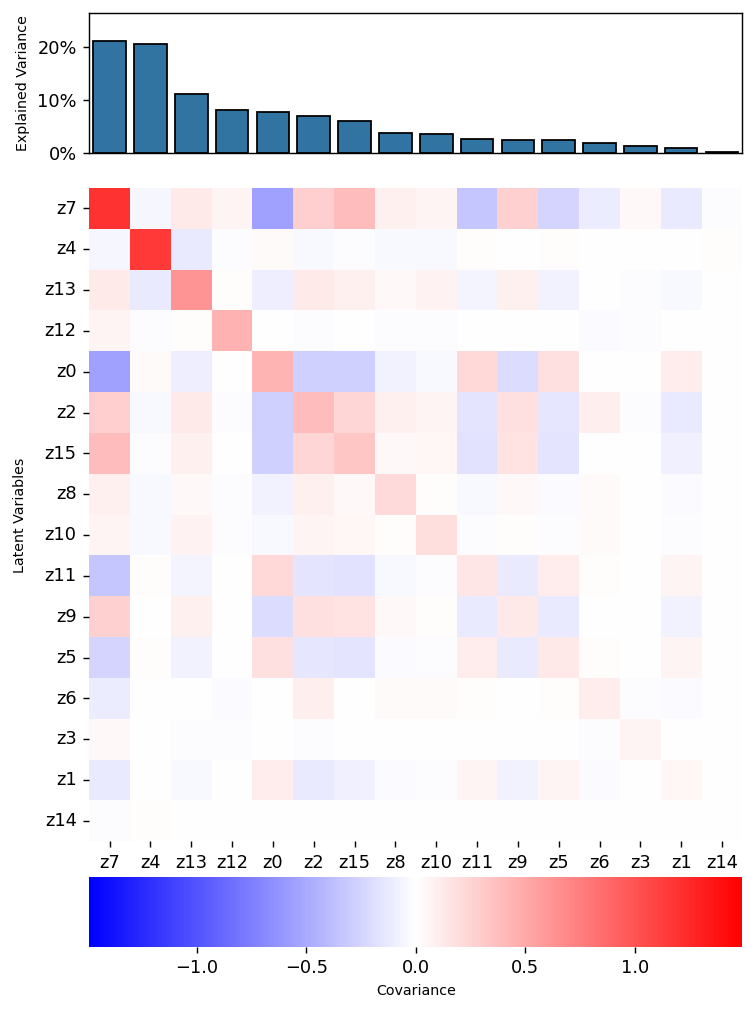

In [ ]:
import matplotlib.ticker as mt

fig, axs = plt.subplot_mosaic(
    "AA;BB;CC",
    gridspec_kw={"height_ratios": [0.2, 2, 0.1]},
    figsize=(6, 8),
    dpi=128,
)

# Get variance (and normalized)
latent_var = adata.obsm["X_gmvae"].var()
latent_var_norm = latent_var / latent_var.sum()
order = latent_var_norm.sort_values(ascending=False).index

ax_top = axs["A"]
y_max = max(latent_var_norm)
y_max += y_max * 0.25
sns.barplot(latent_var_norm.loc[order], ax=ax_top, edgecolor="k")
ax_top.set_xticks([])
ax_top.set_ylim(0, y_max)
ax_top.yaxis.set_major_formatter(mt.PercentFormatter(1.0, decimals=0))
ax_top.set_ylabel("Explained Variance", fontsize=8)

# Middle panel: covariance heatmap
ax_hm = axs["B"]
ax_hm.set_aspect("equal")

cov_df = adata.obsm["X_gmvae"].cov().loc[order, order]
max_bound = np.max(cov_df.abs())
max_bound += max_bound * 0.25
sns.heatmap(
    cov_df,
    ax=ax_hm,
    cbar_ax=axs["C"],
    cmap="bwr",
    vmin=-max_bound,
    vmax=max_bound,
    cbar_kws={"use_gridspec": False, "location": "bottom"},
)

ax_hm.set_yticklabels(ax_hm.get_yticklabels(), rotation=0)
ax_hm.set_ylabel("Latent Variables", fontsize=8, labelpad=10)

# Bottom panel: colorbar axis label
axs["C"].set_xlabel("Covariance", fontsize=8)

# Spacing
fig.subplots_adjust(hspace=-0.75)
fig.tight_layout()

## UMAP Interpretation

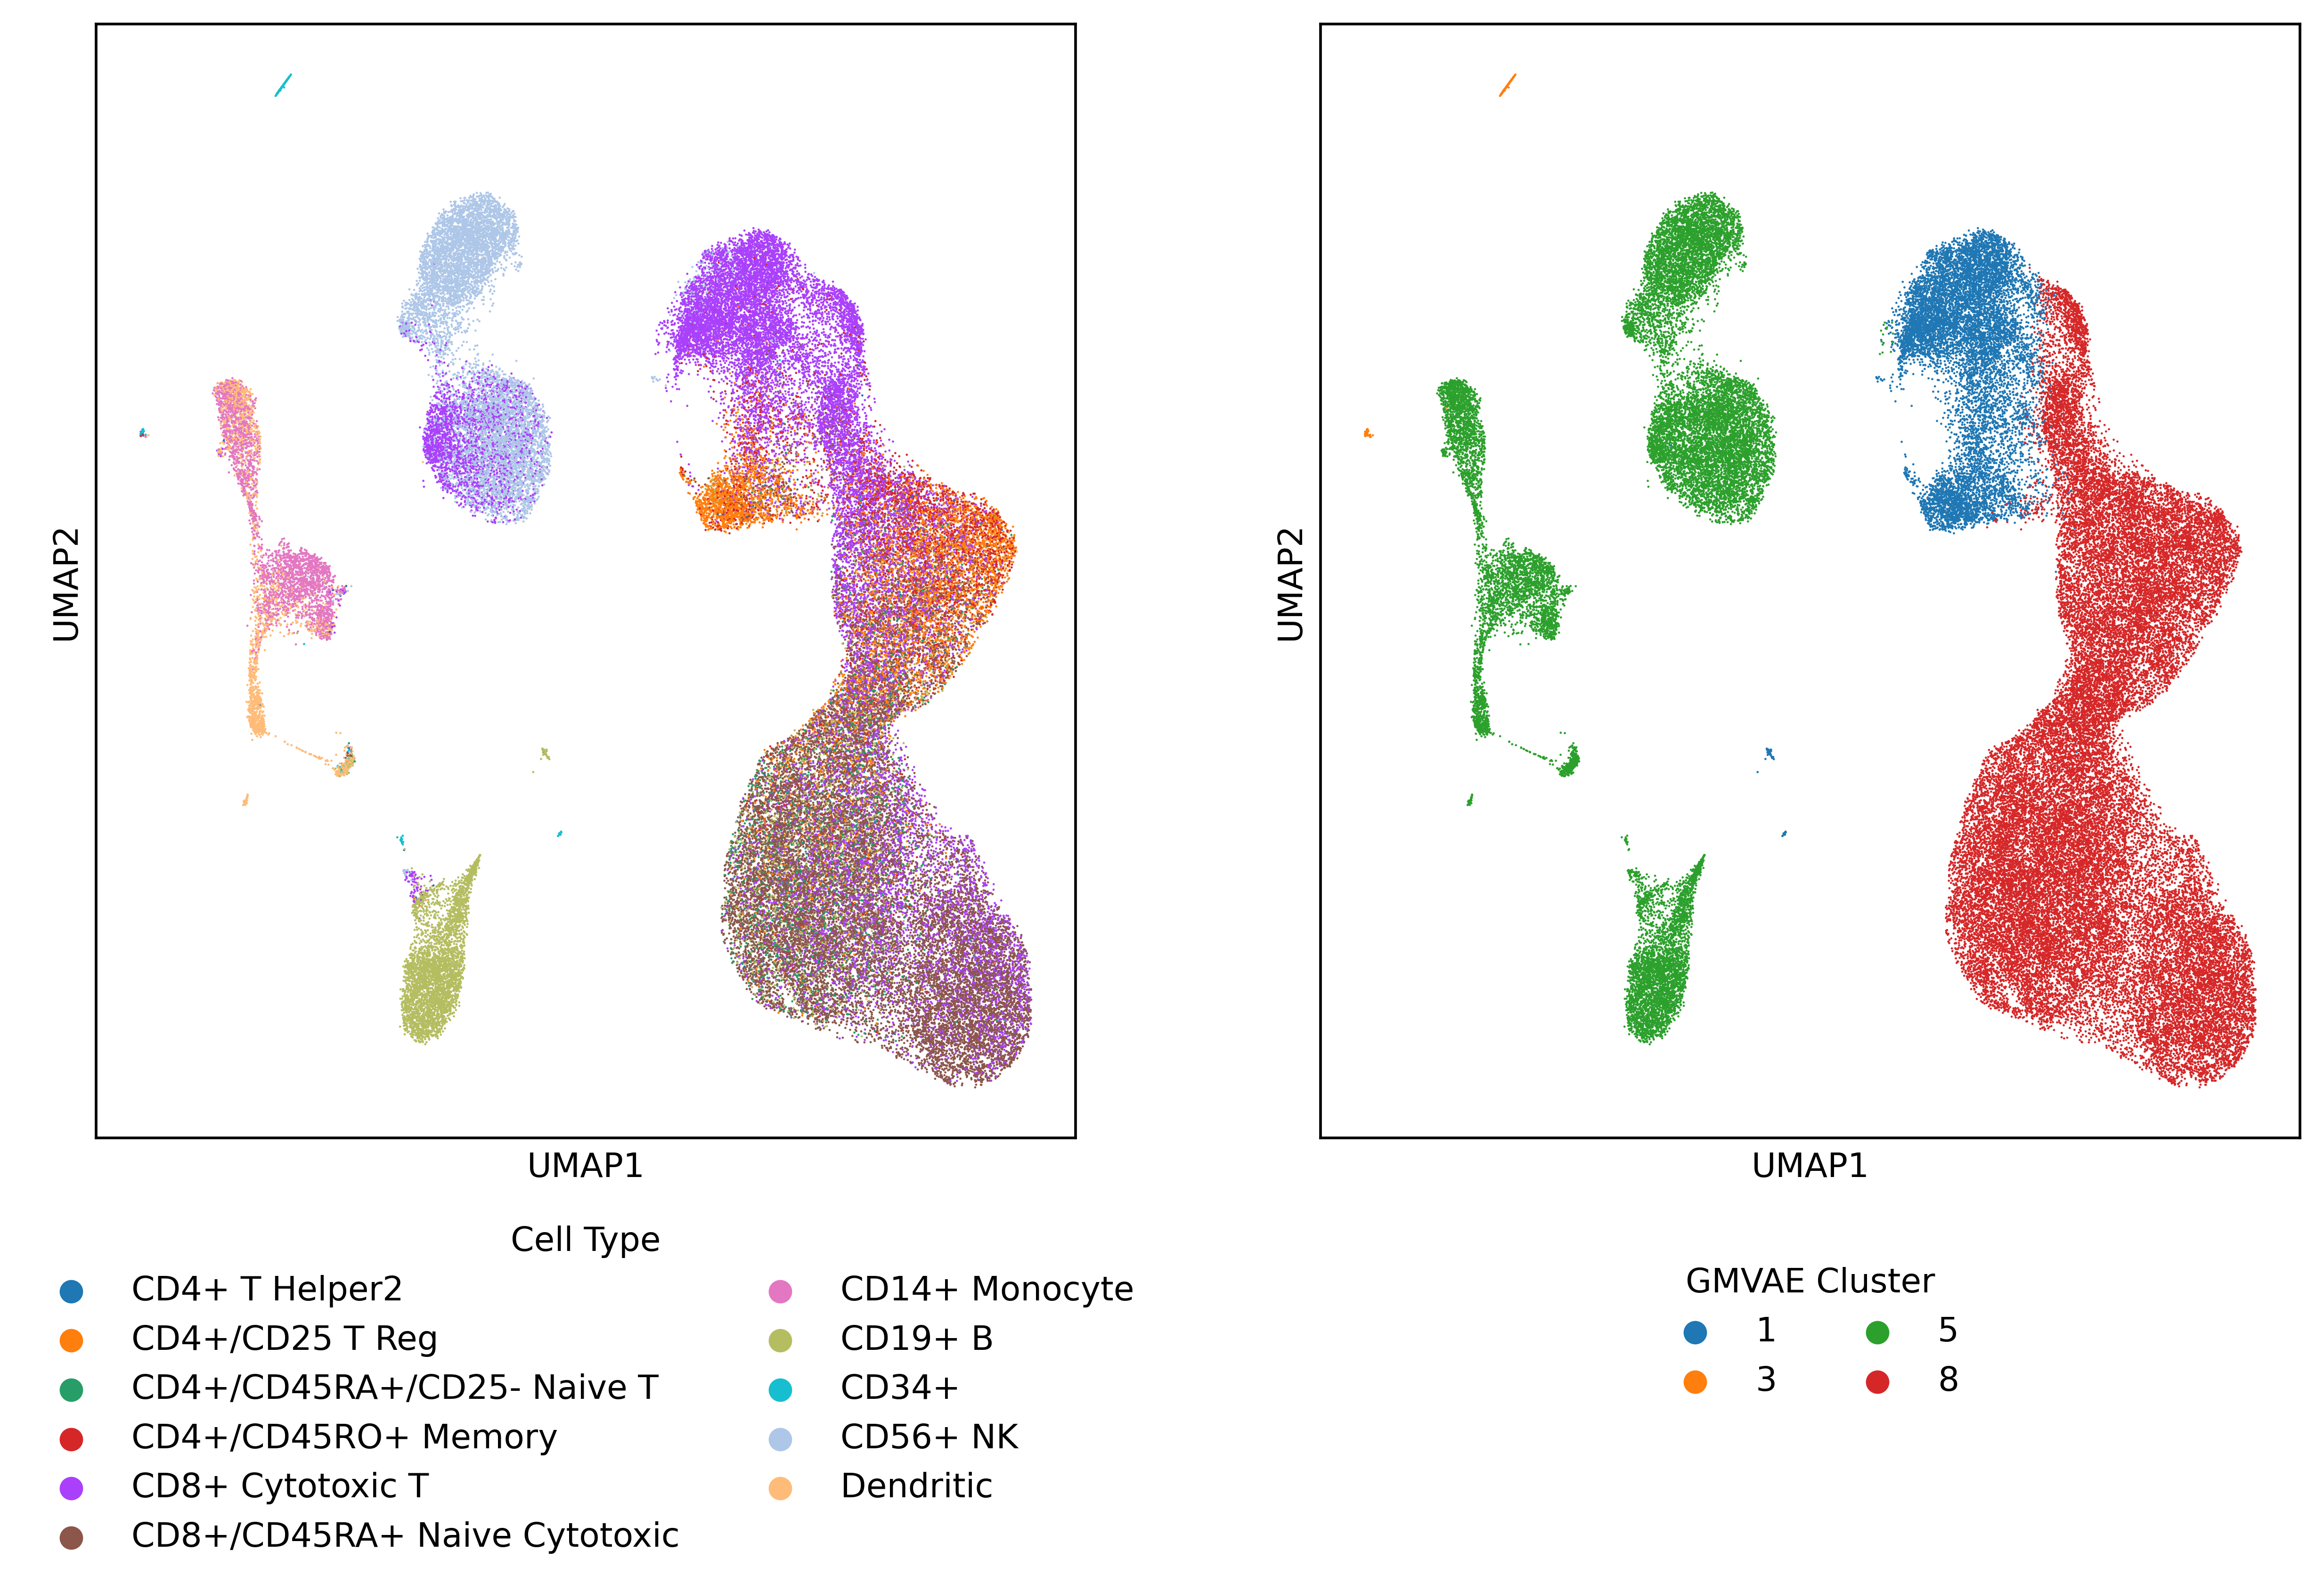

In [ ]:
fig = sc.pl.embedding(
    adata,
    basis="umap_gmvae",
    color=["cell_type", "gmvae_cluster"],
    return_fig=True,
    show=False,
)

fig.set_dpi(512)
fig.set_figheight(6)
fig.set_figwidth(12)

legend_titles = ["Cell Type", "GMVAE Cluster"]

for ax, legend_title in zip(fig.axes, legend_titles):
    ax.set_title(None)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

    if ax.legend_ is not None:
        haffine = -0.4 if legend_title == "Cell Type" else -0.26
        ax.legend(
            *ax.get_legend_handles_labels(),
            title=legend_title,
            loc="lower center",
            ncols=2,
            bbox_to_anchor=(0.5, haffine),
            frameon=False,
        )

fig.tight_layout()

## Linear Decoder Interpretation

### Extract Decoder Loadings

In [ ]:
with torch.inference_mode():
    rate_w, gate_nb_w, gate_zi_w = gmvae.decoder.probs_proj.weight.chunk(3)

    latent_cols = [f"w{i}" for i in range(num_latents)]
    var_names = adata.var_names

    adata.varm["rate_loadings"] = pd.DataFrame(
        rate_w.detach().cpu().numpy(),
        index=var_names,
        columns=latent_cols,
    )
    adata.varm["gate_nb_loadings"] = pd.DataFrame(
        gate_nb_w.detach().cpu().numpy(),
        index=var_names,
        columns=latent_cols,
    )
    adata.varm["gate_zi_loadings"] = pd.DataFrame(
        gate_zi_w.detach().cpu().numpy(),
        index=var_names,
        columns=latent_cols,
    )

# Interpret rate loadings from linear decoder, inspired by scVI's LDVAE tutorial
rate_loadings = adata.varm["rate_loadings"]

sep = "-" * 95
print("Top rate loadings by magnitude")
print(sep)

for latent in rate_loadings.columns:
    s = rate_loadings[latent].sort_values(ascending=False)

    top5 = "\t".join(f"{idx}, {s.loc[idx]:.2f}" for idx in s.head(5).index)
    bot5 = "\t".join(f"{idx}, {s.loc[idx]:.2f}" for idx in s.tail(5).index)

    print(f"{latent}:\t{top5}\n\t...\n\t{bot5}\n{sep}\n")

Top rate loadings by magnitude
-----------------------------------------------------------------------------------------------
w0:	SLC4A10, 0.93	PRSS35, 0.87	TPO, 0.86	GATA2, 0.84	CRISPLD2, 0.78
	...
	RRM2, -0.60	HLA-DPA1, -0.60	CCNA2, -0.61	HLA-DQA2, -0.61	HLA-DRB5, -0.61
-----------------------------------------------------------------------------------------------

w1:	FOXP3, 0.86	NUSAP1, 0.80	C15orf53, 0.77	RP11-1399P15.1, 0.74	CCR3, 0.74
	...
	LAT2, -0.52	CXXC5, -0.54	TYROBP, -0.54	FGR, -0.55	SYK, -0.58
-----------------------------------------------------------------------------------------------

w2:	PTGDS, 0.95	SCAMP5, 0.93	TPM2, 0.91	LILRA4, 0.88	SCT, 0.82
	...
	EGR1, -0.56	CPNE2, -0.58	SPTSSB, -0.61	GZMK, -0.62	DUSP2, -0.63
-----------------------------------------------------------------------------------------------

w3:	RP5-887A10.1, 0.55	TNFSF13B, 0.53	IGJ, 0.49	PLCD1, 0.49	ADTRP, 0.48
	...
	MYL9, -0.58	ITGA2B, -0.60	AC096559.1, -0.62	PADI4, -0.80	RP5-1028K7.2, -0.84
----

### Visualize Loadings

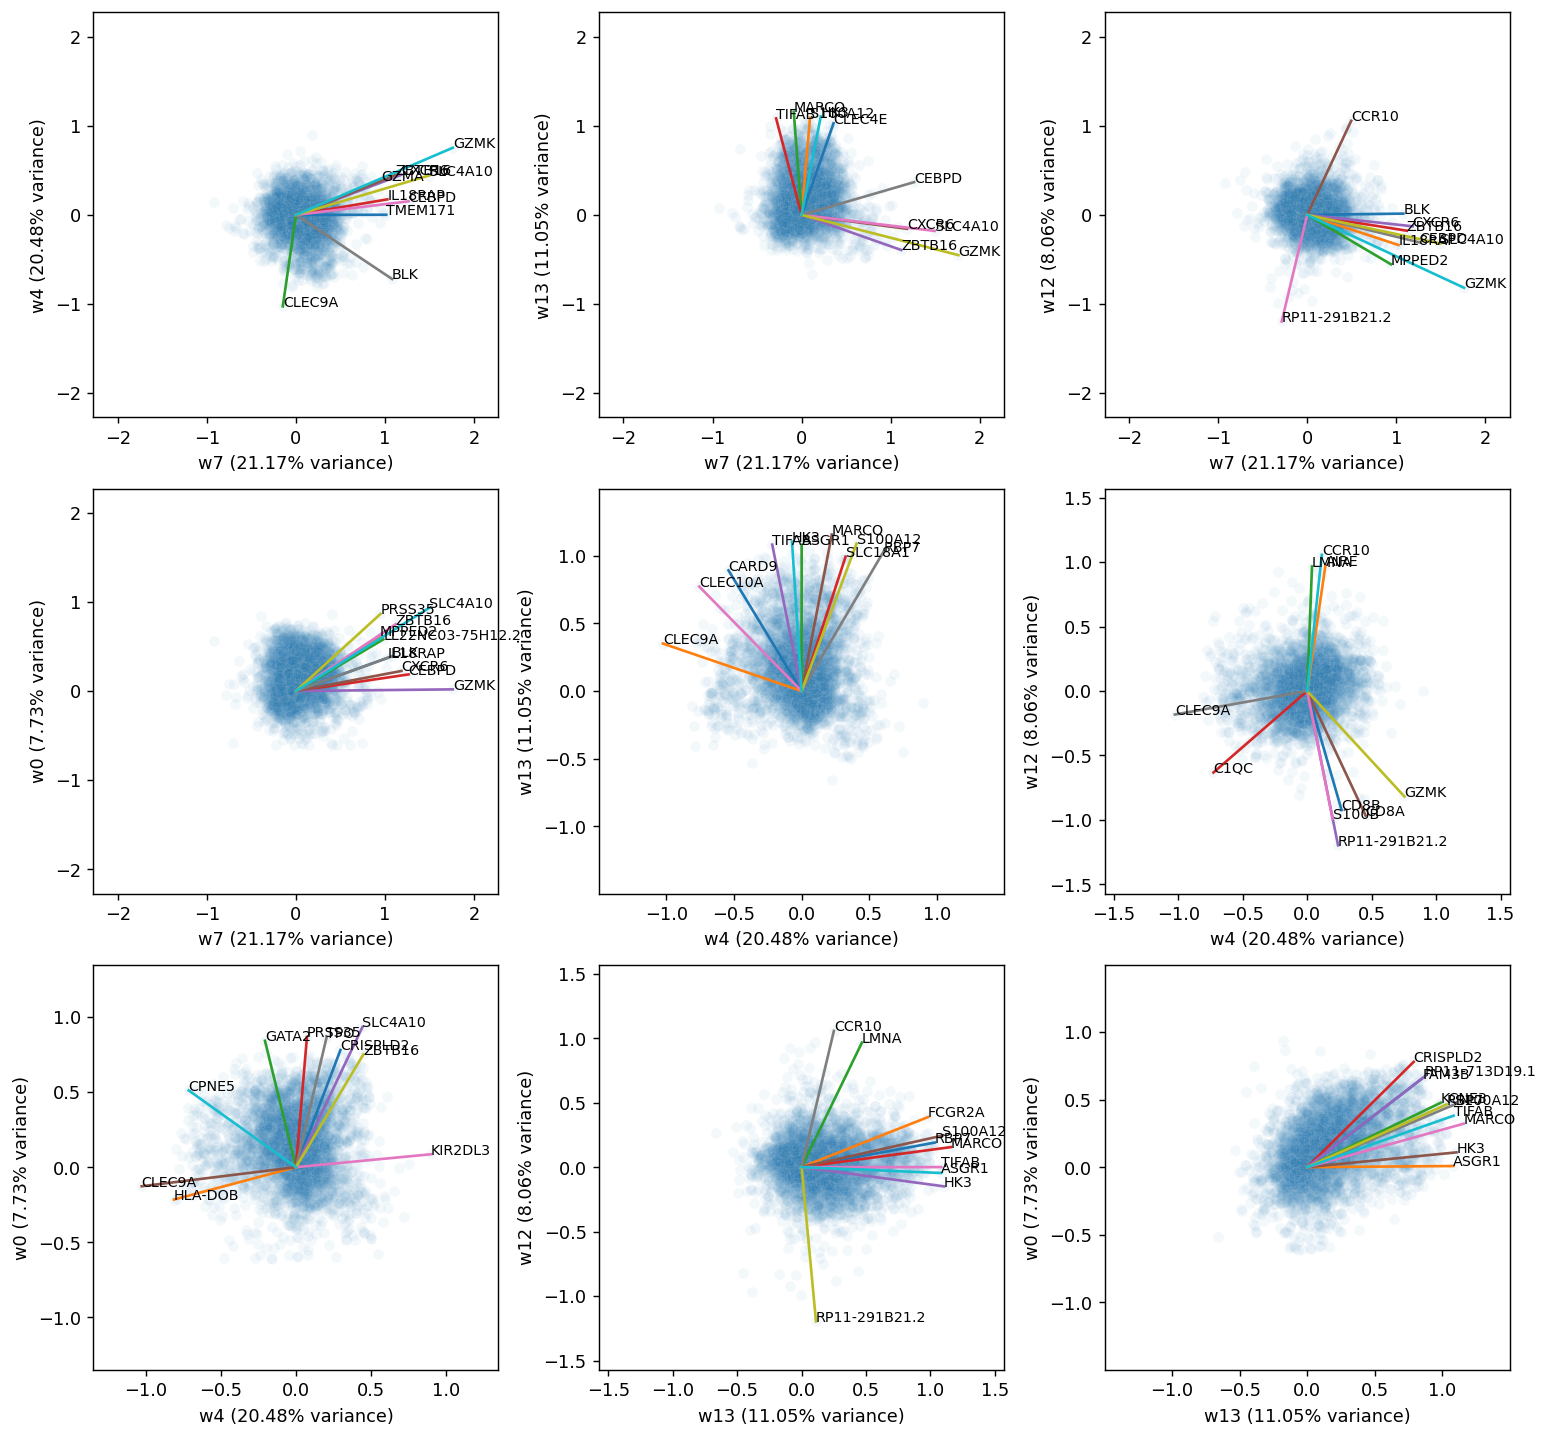

In [ ]:
from itertools import combinations

# Top k observed variable loadings
k = 10

# Figure setup
fig, axs = plt.subplots(3, 3, figsize=(12, 12), dpi=128)
axs = axs.ravel()

# Choose pairs (top-4 variance first)
pairs = combinations(order[:5], 2)

for ax, (zx, zy) in zip(axs, pairs):
    wx, wy = zx.replace("z", "w"), zy.replace("z", "w")
    ax.set_aspect("equal")

    sns.scatterplot(data=rate_loadings, x=wx, y=wy, ax=ax, alpha=0.05)

    # Symmetric bounds around 0
    max_bound = np.abs(ax.get_xlim() + ax.get_ylim()).max()
    max_bound += max_bound * 0.2
    ax.set_xlim(-max_bound, max_bound)
    ax.set_ylim(-max_bound, max_bound)

    # Top-k by L2 norm in the (wx, wy) plane
    norms = np.linalg.norm(rate_loadings[[wx, wy]].to_numpy(), ord=2, axis=1)
    topk_idx = np.argpartition(norms, -k)[-k:]

    # Prefer index alignment (fallback to var_names only if you *know* it's aligned)
    obj_names = rate_loadings.index[topk_idx]

    ax.set_xlabel(f"{wx} ({latent_var_norm.loc[zx]:.2%} variance)")
    ax.set_ylabel(f"{wy} ({latent_var_norm.loc[zy]:.2%} variance)")

    for name in obj_names:
        x, y = rate_loadings.loc[name, [wx, wy]]
        ax.plot([0, x], [0, y])

        ax.annotate(
            " ".join(name.split("_")),
            xy=(x, y),
            xytext=(0, 0),
            textcoords="offset points",
            fontsize=8,
        )

fig.subplots_adjust(wspace=-0.5, hspace=-0.7)
fig.tight_layout()

### Extract Wordcloud from Loading Similarity

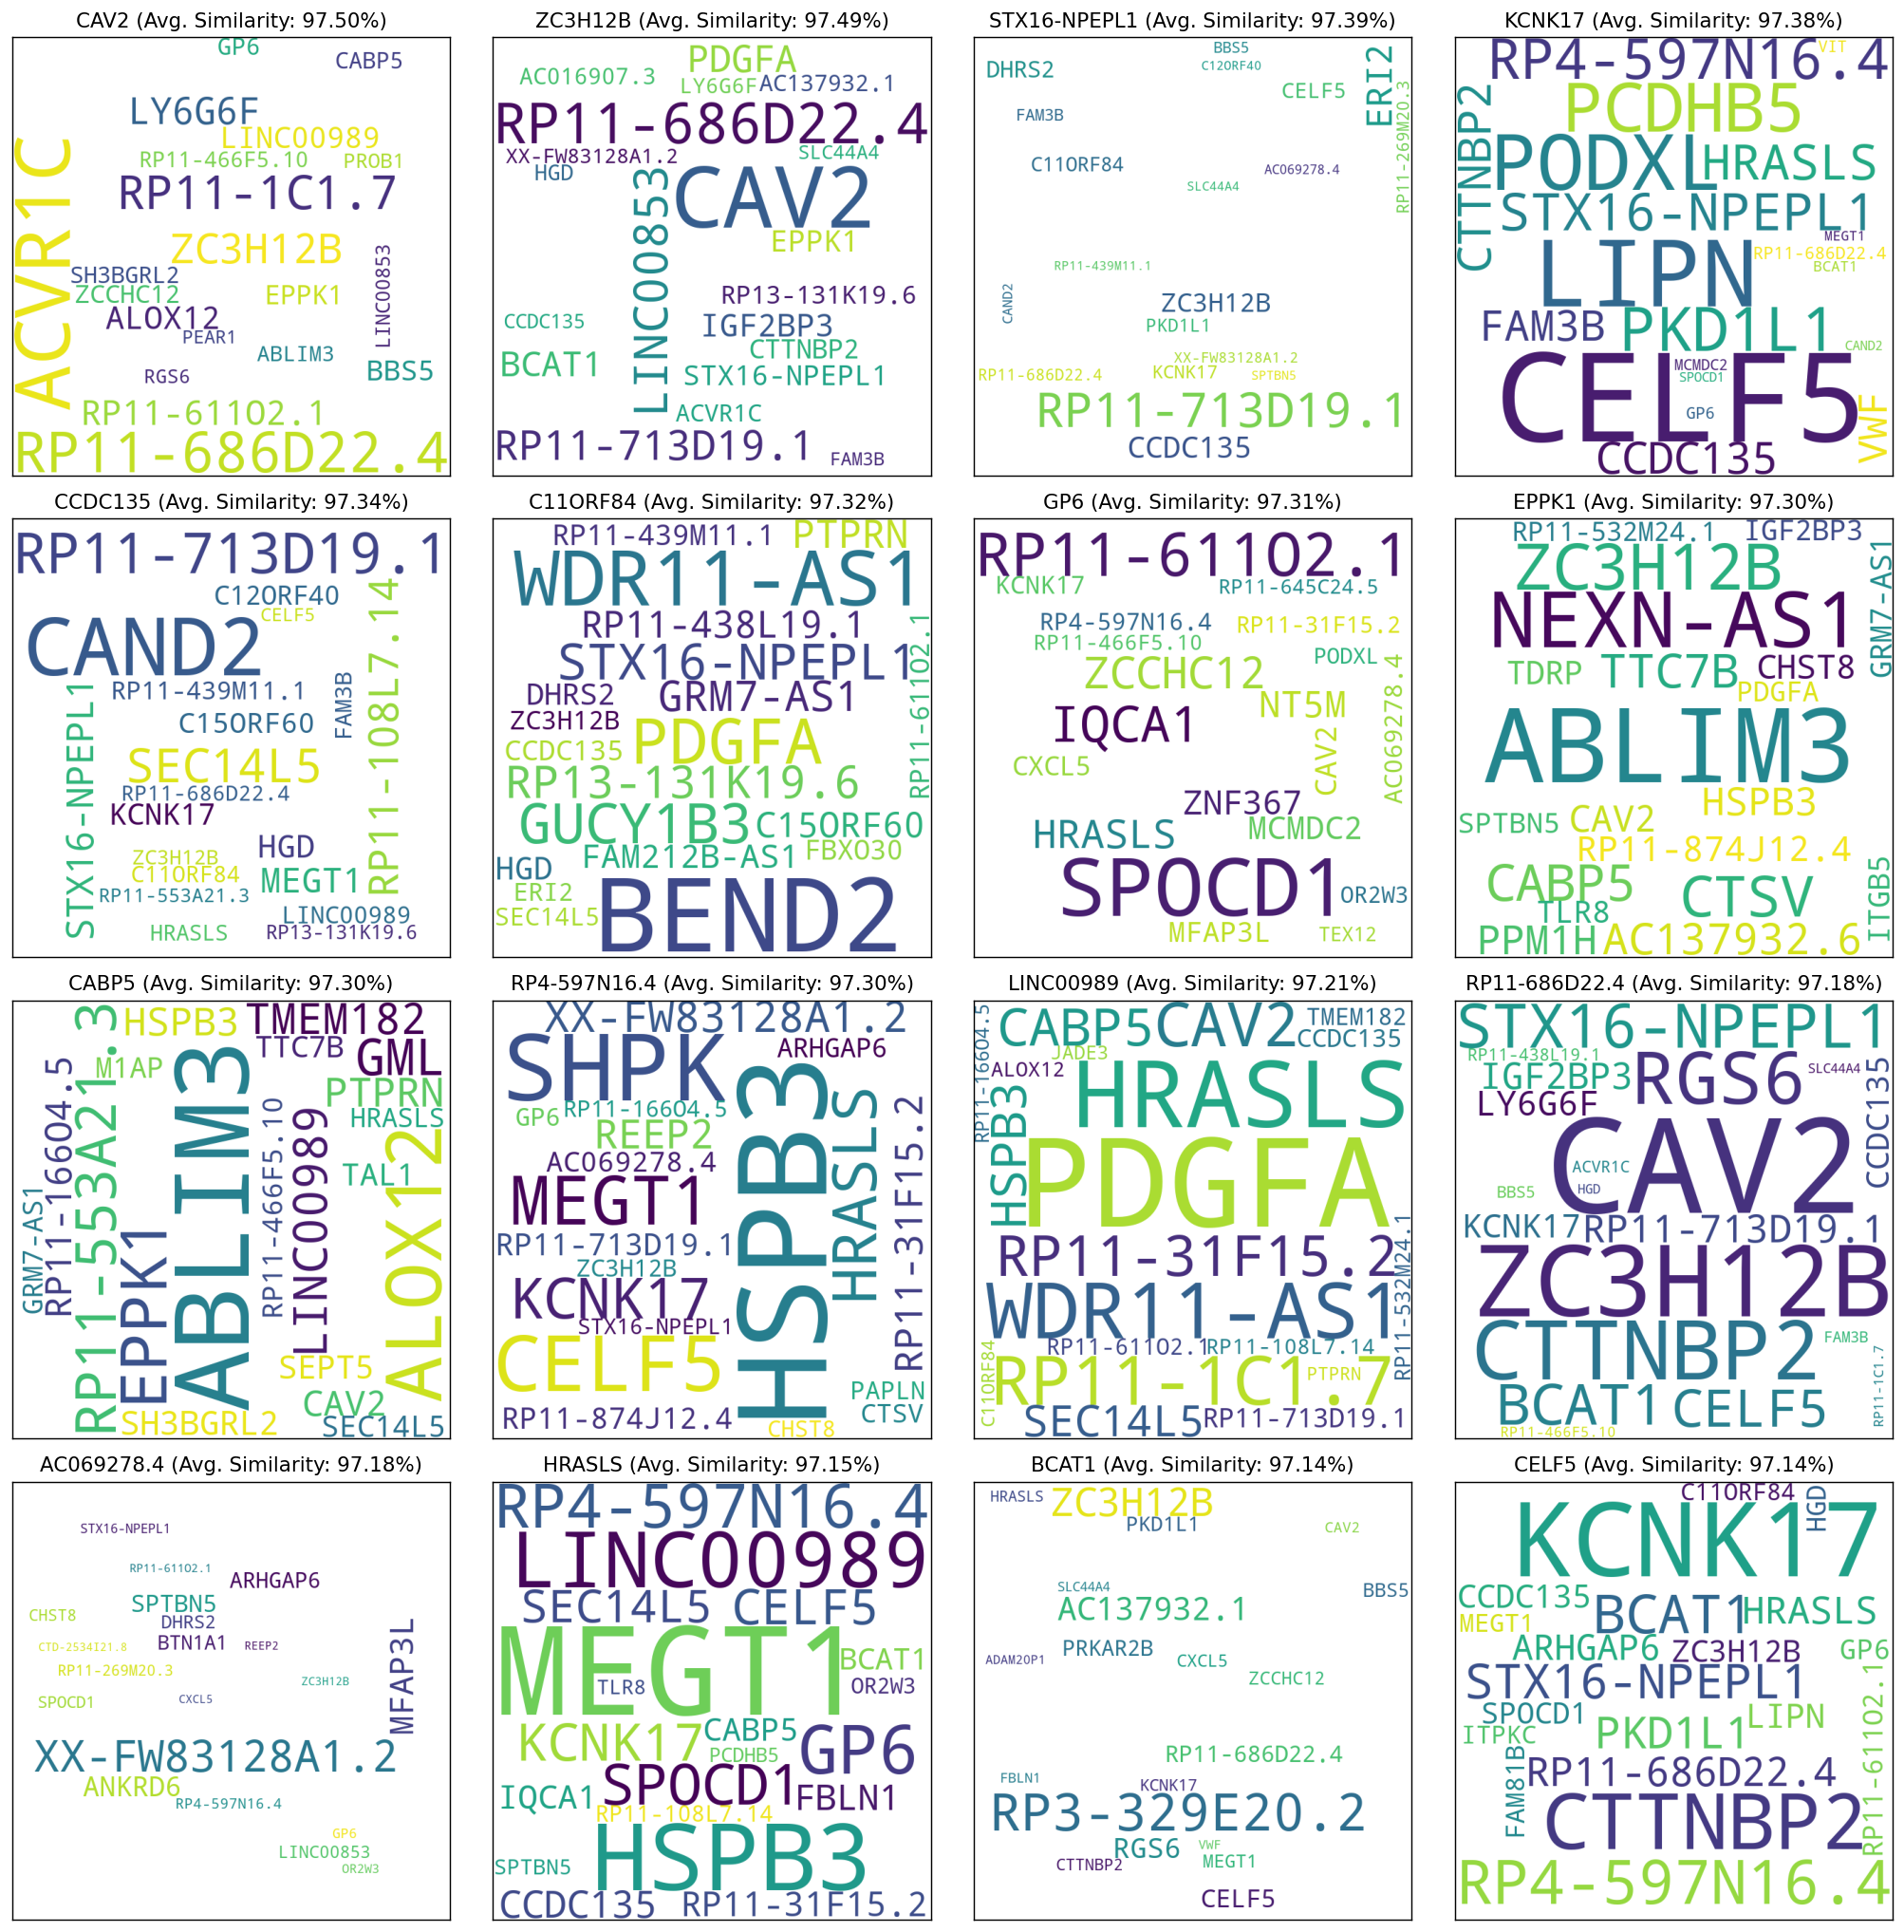

In [ ]:
from sklearn.metrics import pairwise_kernels
from wordcloud import WordCloud

related_objects = {}
sim_values = {}

# Compute (normalized) cosine similarity matrix
cos_sim = pd.DataFrame(
    (pairwise_kernels(rate_loadings, metric="cosine") + 1) / 2,
    index=rate_loadings.index,
    columns=rate_loadings.index,
)

# For each object, take the top-20
for obj_name in rate_loadings.index:
    # Drop self-similarity
    most_similar = cos_sim[obj_name].nlargest(21).iloc[1:]
    related_objects[obj_name] = most_similar.index.tolist()
    sim_values[obj_name] = float(most_similar.mean())

top_objects = sorted(sim_values, key=sim_values.get, reverse=True)

# Plot wordclouds
fig, axs = plt.subplots(4, 4, figsize=(16, 16), dpi=128)
axs = axs.ravel()

wc = WordCloud(
    width=640,
    height=640,
    background_color="white",
    relative_scaling=0.5,
    random_state=seed,
)

for ax, obj_name in zip(axs, top_objects):
    freqs = {
        w.upper().replace("_", " "): 1 / (i + 1)
        for i, w in enumerate(related_objects[obj_name])
    }

    ax.set_aspect("equal")
    ax.set_title(
        f"{obj_name.upper().replace('_', ' ')} "
        f"(Avg. Similarity: {sim_values[obj_name]:.2%})"
    )
    ax.imshow(wc.generate_from_frequencies(freqs))
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()